### Wheelflat Detection

Simple algorithm to detect a wheelflat using ultrasonic equipment data loosely based on the criteria defined in the AAR Manual of Standards and Recommended Practices:

Assumptions:
- Ultrasonic equipment outputs wheel tread profile data 
- Data includes a series of depth measurements across the tread surface `*`
- Hardness is not accounted for in this example
- Threshold values for length and depth are defined as:
  - MAX_DEPTH_THRESHOLD (e.g., 0.020 cm)
  - MIN_LENGTH_THRESHOLD (e.g., 2.0 cm)
  
`*` _Only one type of depth measurement (arbitrary) is used in this example_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Simplified wheelflat detection algorithm

In [2]:
def detect_wheelflat(profile_data, max_depth_threshold, min_length_threshold, sample_spacing):
    """
    Detects a wheelflat on a wheel tread profile.

    Args:
        profile_data (list): List of depth measurements across the tread
        max_depth_threshold (float): Maximum allowable depth threshold (cm)
        min_length_threshold (float): Minimum length of flat (cm)
        sample_spacing (float): Sampling rate of profile data (e.g., distance between consecutive points in cm). Adjust based on equipment settings

    Returns:
        dict: Detection result with "wheelflat_detected" (bool),
              "flat_length" (float), and "flat_depth" (float).
    """

    ##-- Initialize variables
    flat_detected = False
    flat_start = None
    flat_depth = 0

    ##-- Iterate through the profile data to find regions exceeding depth threshold
    for i, depth in enumerate(profile_data):
        if depth >= max_depth_threshold:
            ##-- Start of potential flat
            if flat_start is None:
                flat_start = i
            ##-- Track maximum depth in the region
            flat_depth = max(flat_depth, depth)
        else:
            ##-- End of potential flat
            if flat_start is not None:
                flat_end = i
                flat_length = (flat_end - flat_start) * sample_spacing

                ##-- Check if length exceeds threshold
                if flat_length >= min_length_threshold:
                    flat_detected = True
                    return {
                        "wheelflat_detected": True,
                        "flat_length": flat_length,
                        "flat_depth": flat_depth,
                    }

                ##-- Reset flat tracking
                flat_start = None
                flat_depth = 0

    ##-- No wheelflat detected
    return {
        "wheelflat_detected": False,
        "flat_length": 0,
        "flat_depth": 0,
    }

### Generate sample profile data for wheelflat

In [3]:
def generate_sample_profile_data(num_points, flat_start, flat_end, flat_depth, noise_level):
    """
    Generates sample wheel tread profile data with a simulated flat defect.

    Args:
        num_points (int): Total number of data points in the profile
        flat_start (int): Index where the flat defect starts
        flat_end (int): Index where the flat defect ends
        flat_depth (float): Depth of the flat defect
        noise_level (float): Amplitude of random noise added to the baseline profile

    Returns:
        list: Simulated wheel tread profile data.
    """
    ##-- Baseline profile w/ slight random variations
    np.random.seed(42)  #-- For reproducibility
    baseline_profile = np.random.normal(loc=0.0, scale=noise_level, size=num_points)

    ##-- Introduce flat defect
    baseline_profile[flat_start:flat_end] = flat_depth

    return baseline_profile.tolist()

### Test wheelflat detection

In [4]:
d = {
    "num_points":100,
    "flat_start":40,
    "flat_end":50,
    "flat_depth":0.025,
    "noise_level":0.005,
    "max_depth_threshold":0.020,
    "min_length_threshold":1.0,
    "sample_spacing":0.1,
}

sample_profile_data = generate_sample_profile_data(
    num_points=d["num_points"], 
    flat_start=d["flat_start"], 
    flat_end=d["flat_end"], 
    flat_depth=d["flat_depth"], 
    noise_level=d["noise_level"]
)

result = detect_wheelflat(
    sample_profile_data, 
    max_depth_threshold=d["max_depth_threshold"], 
    min_length_threshold=d["min_length_threshold"], 
    sample_spacing=d["sample_spacing"]
)

print(result)

{'wheelflat_detected': True, 'flat_length': 1.0, 'flat_depth': 0.025}


### Visualize tread depths that exceed threshold for wheelflat

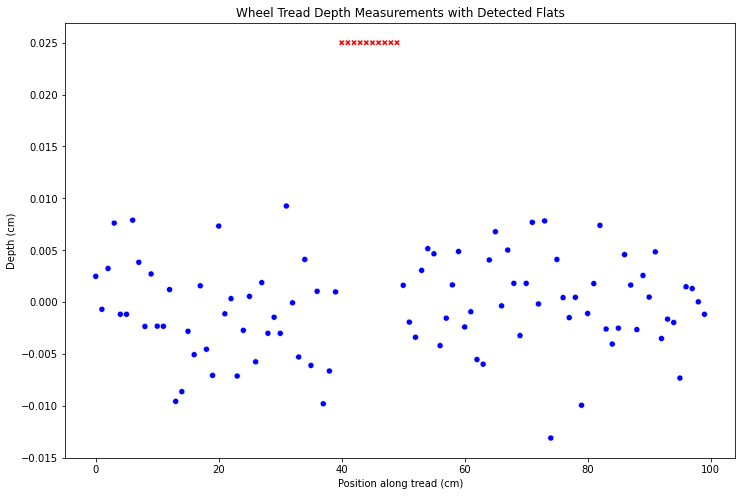

In [7]:
##-- Specify plot width and height (2x default size)
plt.figure(figsize=(12, 8))  

##-- Create an array to hold colors for each point
colors = ['blue'] * len(sample_profile_data)

##-- Highlight points exceeding max_depth_threshold
for i, depth in enumerate(sample_profile_data):
    if depth >= d["max_depth_threshold"]:
        colors[i] = 'red'

##-- Plot data
sns.scatterplot(
    x=np.arange(len(sample_profile_data)), 
    y=sample_profile_data, 
    hue=colors, 
    style=colors,
    palette=['blue', 'red'], 
    legend=False
)

##-- Configure axes
plt.ylabel("Depth (cm)")
plt.xlabel("Position along tread (cm)")
plt.title("Wheel Tread Depth Measurements with Detected Flats")

##-- Show plot
plt.show()

### Caveats
The above use-case is an oversimplified example and is far from all-encompassing. It is simplified for illustrative purposes only. For a real-world use case, the data is more complex and many more variables are considered. 

Recommended Practices M-107/M-208 provides specifications for various classes of carbon steel wheels used in locomotives and cars. 

The primary specifications include:
- Size: The standard wheel types, tread, and flange contours, along with their respective dimensions and tolerances (illustrated in Figures B.8 through B.14). These figures provide detailed specifications for the wheel's diameter, tape size, flange thickness, and other critical dimensions.
- Hardness: The Brinell Hardness Number (BHN) is used to measure the hardness of the wheel rim. There are minimum and maximum hardness values for each wheel class (provided in Table 10.1). For example, Class L wheels must have a minimum hardness of 255 BHN and a maximum hardness of 321 BHN.

Additional specifications include:
- Permissible Variations: The manual outlines permissible variations in wheel dimensions (Section 9) that are not explicitly covered by tolerances in the figures. These variations account for factors like inside diameter, rim thickness, hub wall thickness, rotundity, and bore diameter.
- Additional Specifications: The manual also includes specifications for other aspects of the wheel's design and manufacturing, such as heat treatment requirements, shot peening, chemical composition, and ultrasonic inspection.